# Spatiotemporal distribution of AxFUCCI cells

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import os
import seaborn as sns 
from pyabc import (Distribution, History)

In [41]:
# Experiments
outgrowth_df = pd.read_csv('./outgrowth.csv')
outgrowth_df.set_index(['day', 'tail'], inplace=True)
outgrowth_mean = outgrowth_df.groupby('day').mean()['outgrowth']

percentage_df = pd.read_csv('./percentage_100um.csv')
df = percentage_df
for day in range(0,6):
    df.loc[df['day'] == day, 'position'] = (outgrowth_mean[day] - (df.loc[df['day'] == day, 'position']-100)).astype(int)
percentage_df = df
percentage_df.set_index(['day', 'tail', 'position'], inplace=True)
percentage_df = percentage_df.drop(['unlabelled'], axis=1)
experiments = percentage_df

In [42]:
means,stds = {},{}
for day,df_day in percentage_df.groupby(level='day'):
        tails_mean, tails_std = {},{}
        for tail,df_animal in df_day.groupby(level='tail'):
            db_path = ("sqlite:///" + os.path.join("./fitting_results/",
                                               "sp_fitting-day="+str(day)+"-tail="+str(tail)+".db"))
            h = History(db_path)       
            df = h.get_distribution(m=0)
            tails_mean[tail] = df[0].mean()
            tails_std[tail] = df[0].std()         
        means[day] = pd.DataFrame.from_dict(tails_mean, orient='index')
        stds[day] = pd.DataFrame.from_dict(tails_std, orient='index')
means = pd.concat(means, names=['day','tail'])   
means['sp'] = outgrowth_mean-means['sp']
stds = pd.concat(stds, names=['day','tail'])   
day_means = means.groupby('day').mean()
day_std = means.groupby('day').std()

In [7]:
# Kolmogorov-Smirnov statistic

significance = 0.05
for day in range(0,6):
    print("Day",day)
    green   = scipy.stats.ks_2samp(means.xs(day,level='day')['c1g'],means.xs(day,level='day')['c2g'])
    magenta = scipy.stats.ks_2samp(means.xs(day,level='day')['c1m'],means.xs(day,level='day')['c2m'])
    print("Green:",green)
    print("H0:",green[1]>significance)
    print("Magenta",magenta)
    print("H0:",magenta[1]>significance)

Day 0
Green: KstestResult(statistic=0.4, pvalue=0.873015873015873)
H0: True
Magenta KstestResult(statistic=0.4, pvalue=0.873015873015873)
H0: True
Day 1
Green: KstestResult(statistic=0.4, pvalue=0.873015873015873)
H0: True
Magenta KstestResult(statistic=0.6, pvalue=0.35714285714285715)
H0: True
Day 2
Green: KstestResult(statistic=0.8, pvalue=0.07936507936507936)
H0: True
Magenta KstestResult(statistic=0.8, pvalue=0.07936507936507936)
H0: True
Day 3
Green: KstestResult(statistic=0.5, pvalue=0.474025974025974)
H0: True
Magenta KstestResult(statistic=0.5, pvalue=0.474025974025974)
H0: True
Day 4
Green: KstestResult(statistic=1.0, pvalue=0.028571428571428577)
H0: False
Magenta KstestResult(statistic=1.0, pvalue=0.028571428571428577)
H0: False
Day 5
Green: KstestResult(statistic=1.0, pvalue=0.028571428571428577)
H0: False
Magenta KstestResult(statistic=1.0, pvalue=0.028571428571428577)
H0: False


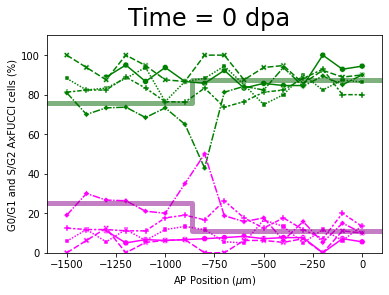

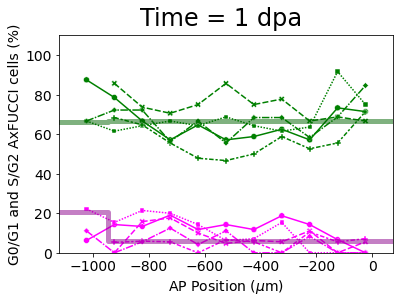

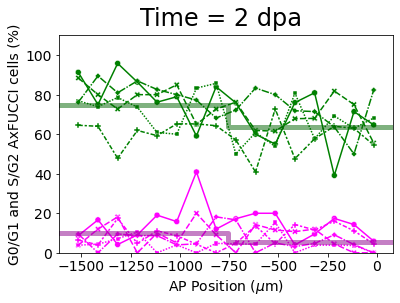

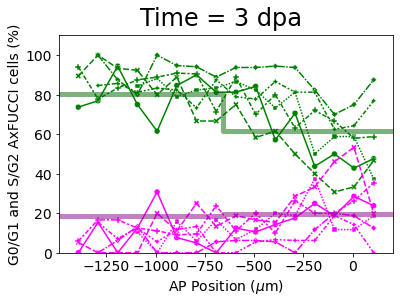

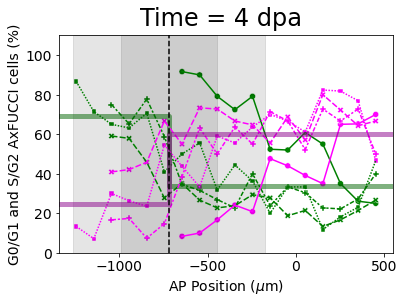

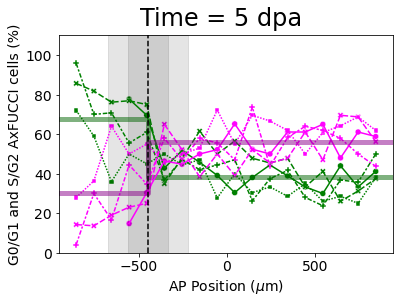

In [51]:
# Local fitting plots (green)
for day in range(0,6):
    sp_mean = means.groupby('day')['sp'].mean().iloc[day]
    sp_std  = means.groupby('day')['sp'].std().iloc[day]
    c1g = means.groupby('day')['c1g'].mean().iloc[day]
    c2g = means.groupby('day')['c2g'].mean().iloc[day]
    c1g_std = means.groupby('day')['c1g'].std().iloc[day]
    c2g_std = means.groupby('day')['c2g'].std().iloc[day]
    
    c1m = means.groupby('day')['c1m'].mean().iloc[day]
    c2m = means.groupby('day')['c2m'].mean().iloc[day]
    c1m_std = means.groupby('day')['c1m'].std().iloc[day]
    c2m_std = means.groupby('day')['c2m'].std().iloc[day]    
    
    pos = experiments.sort_index().xs(day,level='day').groupby('position').mean().dropna().index
    data = experiments.sort_index().xs(day,level='day').reset_index().dropna()

    ax = sns.scatterplot(x='position', y='green', data=data,style='tail',color='green')
    ax = sns.lineplot(x='position', y='green', data=data,style='tail',color='green')
    
    ax.step([-3000,sp_mean,sp_mean,3000], [c2g,c2g,c1g,c1g], color='darkgreen',linewidth=5, alpha=0.5)
    
    ax = sns.scatterplot(x='position', y='magenta', data=data,color='magenta',style='tail')
    ax = sns.lineplot(x='position', y='magenta', data=data,color='magenta',style='tail')

    ax.step([-3000,sp_mean,sp_mean,3000], [c2m,c2m,c1m,c1m], color='darkmagenta',linewidth=5, alpha=0.5)

    if day == 4:
        plt.axvline(-717.65,color='black',linestyle='--')
        plt.axvspan(-717.65-271.9, -717.65+271.9, color='black', alpha=0.1)
        plt.axvspan(-717.65-2*271.9, -717.65+2*271.9, color='black', alpha=0.1)
    if day == 5:
        plt.axvline(-446.43,color='black',linestyle='--')
        plt.axvspan(-446.43-112.46, -446.43+112.46, color='black', alpha=0.1)   
        plt.axvspan(-446.43-2*112.46, -446.43+2*112.46, color='black', alpha=0.1)
    title = 'Time = '+ str(day)+" dpa"
    plt.xlim(data['position'].min()-100,data['position'].max()+100)
    plt.ylim(0,110)
    plt.xlabel('AP Position' + ' (' + r'$\mu$'+'m)')
    plt.ylabel('G0/G1 and S/G2 AxFUCCI cells (%)')
    plt.suptitle(title,size='24')    
    plt.rcParams.update({'font.size': 14})
    plt.legend([],[], frameon=False)
    plt.savefig('./fit_plot2/ap-border_'+str(day), dpi=300, bbox_inches='tight')
    plt.show()